# **Flood Detection Deep Learning Model.**
This model takes a satellite image as an input then it tells us whether the area is damaged by flood or not.

In [7]:
from fastai.vision.all import *

**Loading the Data**

In [9]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive (1).zip


In [10]:
import zipfile
import os

# Ensuring the current working directory in Colab is the home directory
os.chdir('/content')

# Unziping the dataset
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extract into a folder named 'dataset'

# Checking if the dataset is extracted properly
os.listdir('dataset')

['models', 'test', 'train_another', 'test_another', 'validation_another']

**Applying Preprocessing techniques, data augmentation and conducting EDA.**






In [11]:
# Setting the path to the main folder where the data folders are located
path = Path('/content/dataset')

# Loading the data into DataLoaders
dls = ImageDataLoaders.from_folder(
    path,
    train='train_another',
    valid='validation_another',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),  # Applying default data augmentations
    bs=32  # Setting batch size
)

**Getting a visual glimpse of our data to ensure it is successfully loaded**

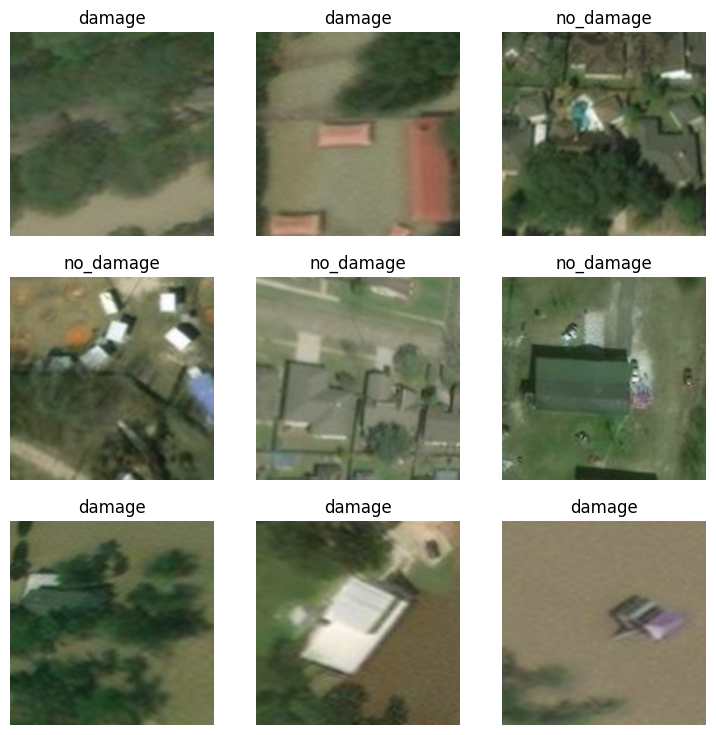

In [12]:
import matplotlib.pyplot as plt

dls.show_batch()

**Inspecting our Dataset**

In [13]:
def count_images(path):
    return {cls.name: len(get_image_files(cls)) for cls in path.ls()}

train_path = path/'train_another'
valid_path = path/'validation_another'

train_counts = count_images(train_path)
valid_counts = count_images(valid_path)

print(f"Training set class distribution: {train_counts}")
print(f"Validation set class distribution: {valid_counts}")

Training set class distribution: {'damage': 5000, 'no_damage': 5000}
Validation set class distribution: {'damage': 1000, 'no_damage': 1000}


**Analyzing our the properties of our dataset**

In [14]:
from PIL import Image

def analyze_image_properties(image_files):
    sizes = []
    for im_path in image_files:
        with Image.open(im_path) as im:
            sizes.append(im.size)
    return sizes

# Getting file paths for the damage and no_damage classes
damage_files = get_image_files(train_path/'damage')
no_damage_files = get_image_files(train_path/'no_damage')

# Analyzing properties
damage_sizes = analyze_image_properties(damage_files)
no_damage_sizes = analyze_image_properties(no_damage_files)

# calculating average sizes, plot size distributions, etc.
print(f"Average size of 'damage' images: {np.mean(damage_sizes, axis=0)}")
print(f"Average size of 'no_damage' images: {np.mean(no_damage_sizes, axis=0)}")

Average size of 'damage' images: [128. 128.]
Average size of 'no_damage' images: [128. 128.]


In [15]:
dls = ImageDataLoaders.from_folder(
    path,
    train='train_another',
    valid='validation_another',
    item_tfms=Resize(128),
    batch_tfms=[*aug_transforms(max_warp=0), Normalize.from_stats(*imagenet_stats)],
    bs=32
)

**Using Resnet50 Pretrained Model**

In [16]:
# Creating a CNN learner using ResNet50
learn = cnn_learner(dls, resnet50, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


**Finding the learning Rate**

SuggestedLRs(valley=0.0020892962347716093)

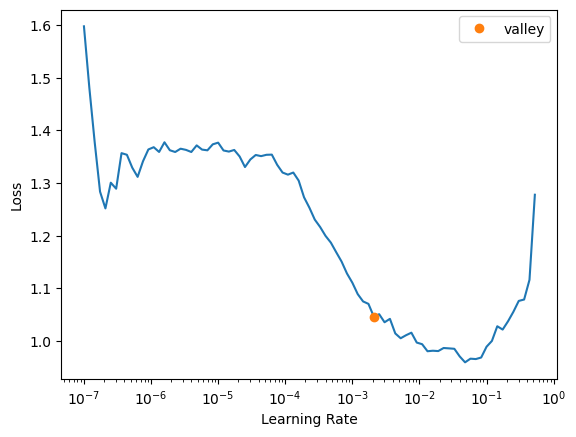

In [17]:
# Finding the optimal learning rate
learn.lr_find()

**Training our Model**



In [18]:
# Using the suggested learning rate from the LR finder
suggested_lr = 0.0020892962347716093

# Fitting one cycle using a similar learning rate range
learn.fit_one_cycle(5, lr_max=slice(suggested_lr/10, suggested_lr))


epoch,train_loss,valid_loss,accuracy,time
0,0.363273,0.254099,0.911000,00:47
1,0.223008,0.183674,0.931000,00:39
2,0.167577,0.133416,0.949500,00:44
3,0.155944,0.130460,0.953000,00:40
4,0.138639,0.114897,0.963000,00:46


**Evaluating our model**

In [19]:
# Evaluating the model on the test(Evaluation) dataset
test_dl = dls.test_dl(get_image_files(path/'test'), with_labels=True)
results = learn.validate(dl=test_dl)
print(f"Test set results: {results}")

Test set results: [0.0869859978556633, 0.9670000076293945]


In [20]:
interp = ClassificationInterpretation.from_learner(learn)

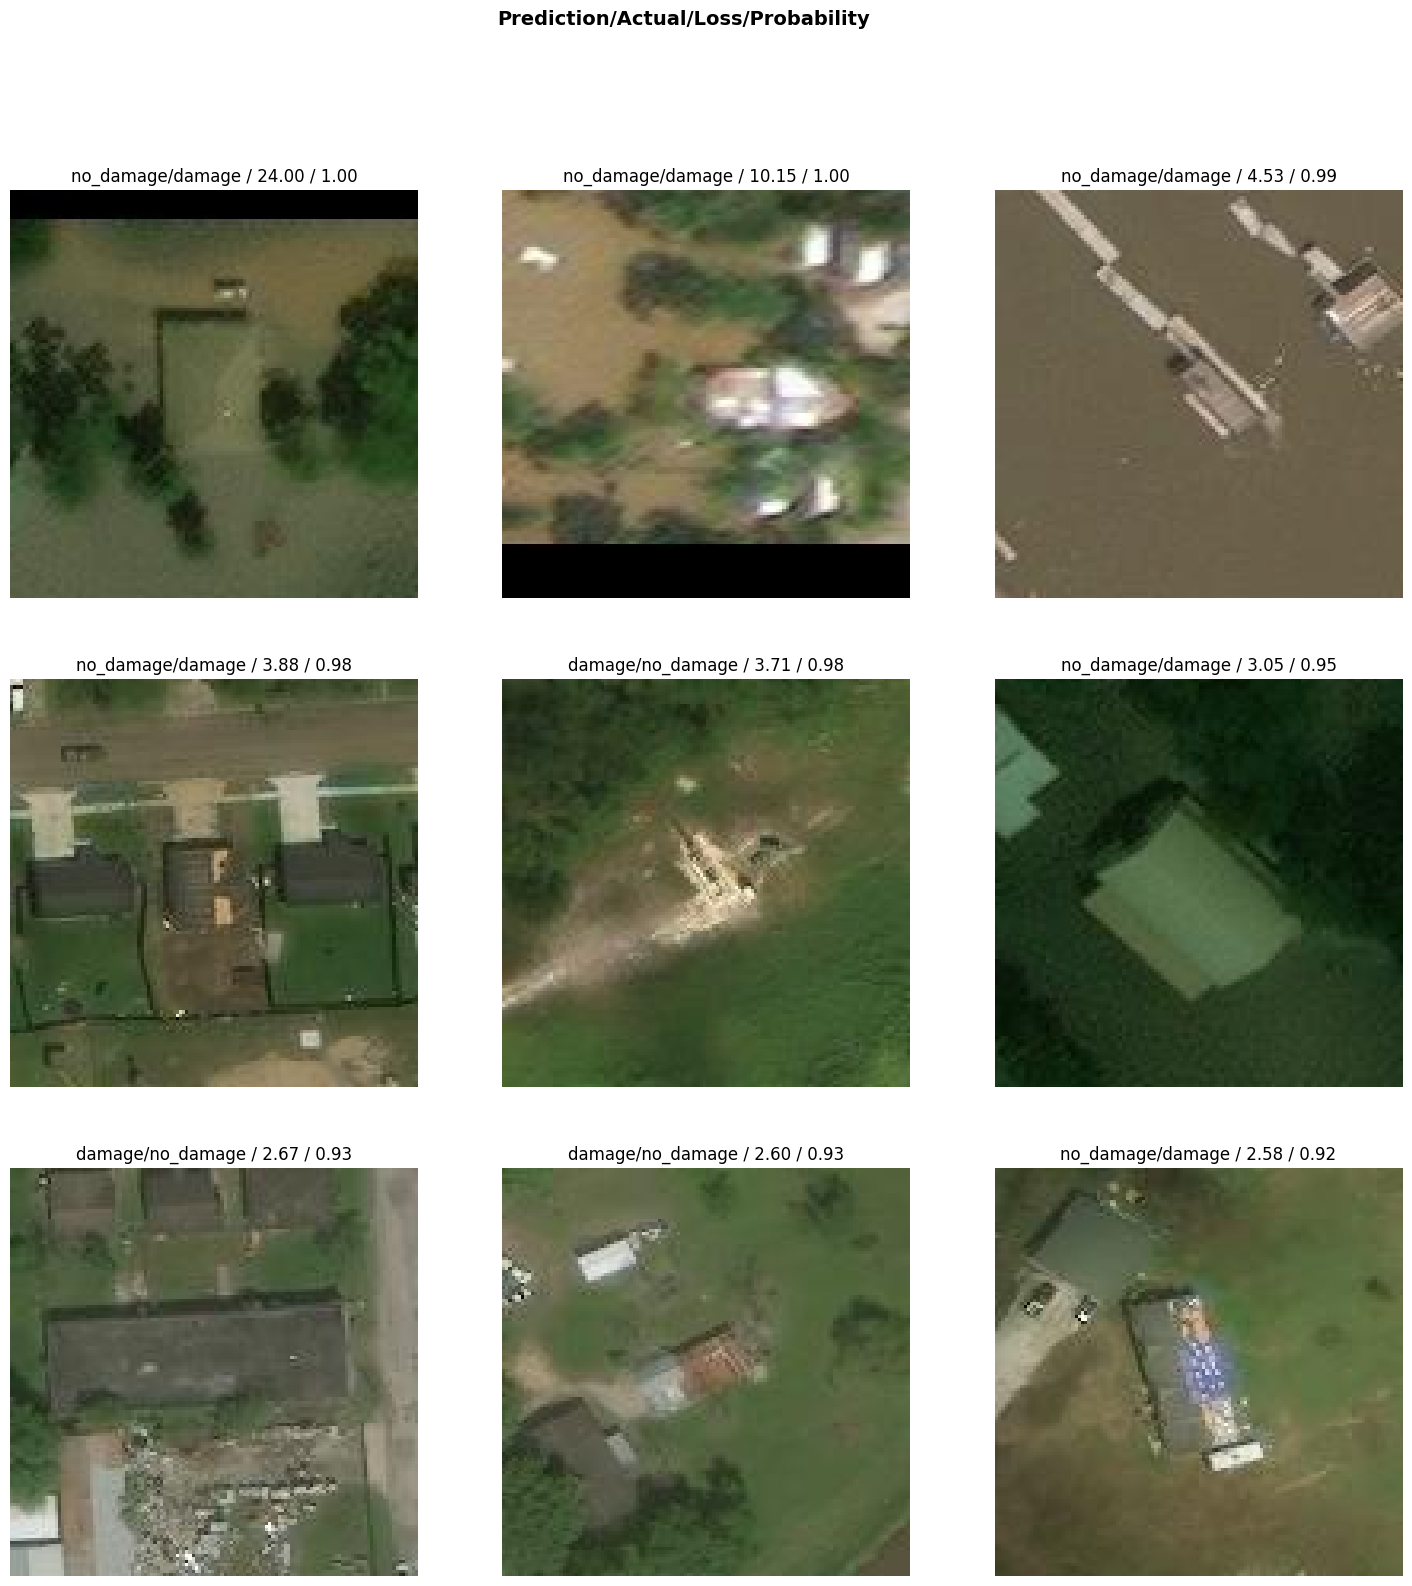

In [21]:
interp.plot_top_losses(9, largest=True, figsize=(18,18))

**Creating a Confusion Matrix**

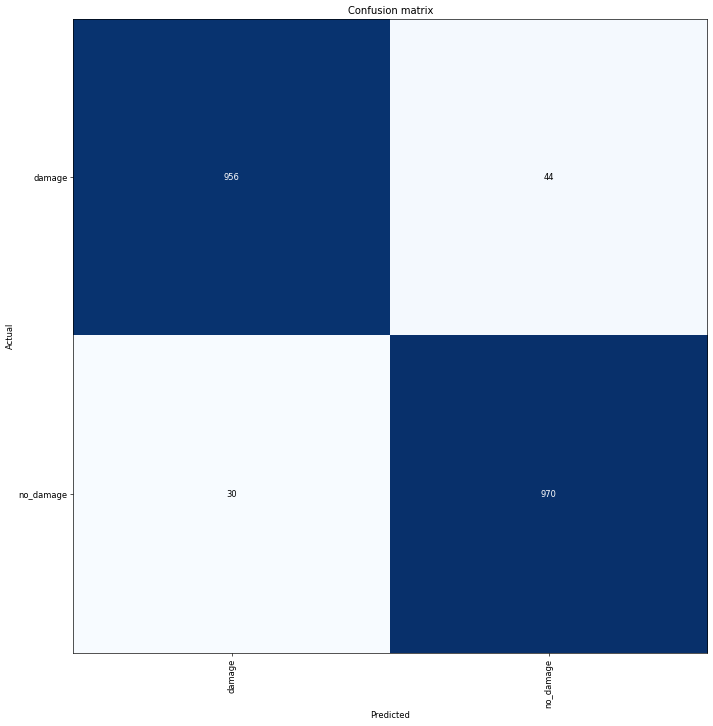

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

**Defining Prediction Function**

In [23]:
def predict(img):
    img_fastai = PILImage.create(img)
    pred, _, probs = learn.predict(img_fastai)
    return {learn.dls.vocab[i]: float(probs[i]) for i in range(len(learn.dls.vocab))}

In [24]:
from fastai.vision.core import PILImage

# Path to the uploaded image in Google Colab
test_image_path = '/content/test.jpeg'
img = PILImage.create(test_image_path)
predict(img)

{'damage': 0.9858010411262512, 'no_damage': 0.014198904857039452}

**Creating a dashboard using Gradio**

In [25]:
# Creating a Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs="image",
    outputs="label"

# Launching the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b581132b7f1348cbe5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [17]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.3 MB/

In [1]:
!pip uninstall -y gradio

Found existing installation: gradio 4.16.0
Uninstalling gradio-4.16.0:
  Successfully uninstalled gradio-4.16.0


In [1]:
!pip install gradio

  Using cached gradio-4.16.0-py3-none-any.whl (16.7 MB)


In [2]:
import gradio as gr